## LSTMを使った株価予測

LSTMは時系列データの予測のために利用されます。時系列データには、ある場所の気温や、来客数、商品の価格など多岐にわたりますが、最もデータを入手しやすい株価をLSTMで予測を行ってみたいと思います。

ただし、ニューラルネットはあくまでも得られたデータの範囲内でしか予測する事が出来ず、想定外の状況になった場合、そのモデルはほぼ意味をなしません。

例えば、コロナショック前の1年前のデータを用いても、コロナショックを予測する事は出来ません。

株価の形成はランダムな要素もあり、LSTMで未来を予測するのは難しいとは思いますが、LSTMに慣れるためにやってみようと思います。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_stock/lstm_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_stock/lstm_nb.ipynb)

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.19.4
tensorflow version :  2.1.0
keras version :  2.2.4-tf


## データの取得

今回は日経平均とアメリカのS&P500の株価のデータの予測を行います。データはそれぞれ以下のサイトからダウンロードしました。

### 日経平均のデータ

- https://indexes.nikkei.co.jp/nkave/index?type=download

### SP500のデータ

- https://kabuoji3.com/stock/download.php


## データの確認
まず最初に日経のデータを見てみます。

In [4]:
!ls 

lstm_nb.ipynb   lstm_nb.py      nikkei.csv      sp500_2019.csv
lstm_nb.md      lstm_nb_files   nikkei_utf8.csv sp500_2020.csv


In [5]:
%%bash
head nikkei.csv

�f�[�^���t,�I�l,�n�l,���l,���l
"2017/01/04","19594.16","19298.68","19594.16","19277.93"
"2017/01/05","19520.69","19602.10","19615.40","19473.28"
"2017/01/06","19454.33","19393.55","19472.37","19354.44"
"2017/01/10","19301.44","19414.83","19484.90","19255.35"
"2017/01/11","19364.67","19358.64","19402.17","19325.46"
"2017/01/12","19134.70","19300.19","19300.19","19069.02"
"2017/01/13","19287.28","19174.97","19299.36","19156.93"
"2017/01/16","19095.24","19219.13","19255.41","19061.27"
"2017/01/17","18813.53","19038.45","19043.91","18812.86"


文字コードがshift-jisになっているので、utf-8に直します。

In [6]:
%%bash
nkf --guess nikkei.csv

Shift_JIS (CRLF)


In [7]:
%%bash
nkf -w nikkei.csv > nikkei_utf8.csv

In [8]:
%%bash
head nikkei_utf8.csv

データ日付,終値,始値,高値,安値
"2017/01/04","19594.16","19298.68","19594.16","19277.93"
"2017/01/05","19520.69","19602.10","19615.40","19473.28"
"2017/01/06","19454.33","19393.55","19472.37","19354.44"
"2017/01/10","19301.44","19414.83","19484.90","19255.35"
"2017/01/11","19364.67","19358.64","19402.17","19325.46"
"2017/01/12","19134.70","19300.19","19300.19","19069.02"
"2017/01/13","19287.28","19174.97","19299.36","19156.93"
"2017/01/16","19095.24","19219.13","19255.41","19061.27"
"2017/01/17","18813.53","19038.45","19043.91","18812.86"


問題ないようなので、pandasで読み込みます。

In [9]:
df = pd.read_csv('nikkei_utf8.csv')

In [10]:
df.head()

,データ日付,終値,始値,高値,安値
0,2017/01/04,19594.16,19298.68,19594.16,19277.93
1,2017/01/05,19520.69,19602.10,19615.40,19473.28
2,2017/01/06,19454.33,19393.55,19472.37,19354.44
3,2017/01/10,19301.44,19414.83,19484.90,19255.35
4,2017/01/11,19364.67,19358.64,19402.17,19325.46


In [11]:
df.tail()

,データ日付,終値,始値,高値,安値
971,2020/12/24,26668.35,26635.11,26764.53,26605.26
972,2020/12/25,26656.61,26708.10,26716.61,26638.28
973,2020/12/28,26854.03,26691.29,26854.03,26664.60
974,2020/12/29,27568.15,26936.38,27602.52,26921.14
975,本資料は日経の著作物であり、本資料の全部又は一部を、いかなる形式によっても日経に無断で複写、...,NaN,NaN,NaN,NaN


最後の行に著作権に関する注意書きがありますが、これを削除します。複写や流布は行いません。

In [12]:
df.drop(index=975, inplace=True)

In [13]:
df.tail()

,データ日付,終値,始値,高値,安値
970,2020/12/23,26524.79,26580.43,26585.21,26414.74
971,2020/12/24,26668.35,26635.11,26764.53,26605.26
972,2020/12/25,26656.61,26708.10,26716.61,26638.28
973,2020/12/28,26854.03,26691.29,26854.03,26664.60
974,2020/12/29,27568.15,26936.38,27602.52,26921.14


データを可視化してみます。コロナショックで大きくへこんでいることがわかりますが、2020年の年末の時点では金融緩和の影響を受けて大幅に上がっています。

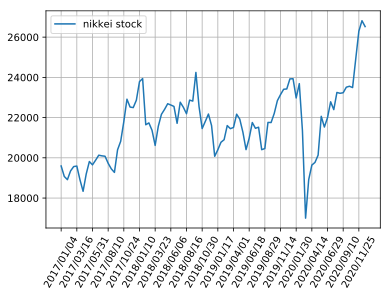

In [14]:
ticks = 10
xticks = ticks * 5 

plt.plot(df['データ日付'][::ticks], df['終値'][::ticks], label='nikkei stock')
plt.grid()
plt.legend()
plt.xticks(df['データ日付'][::xticks], rotation=60)
plt.show()

## データの準備

kerasに投入するためにデータを整えます。

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

NUM_LSTM = 100

x = list(df['データ日付'])
y = list(df['終値'])
print(y[0:100])
print(len(y))
n = len(y) - NUM_LSTM
l_x = np.zeros((n, NUM_LSTM))
l_y = np.zeros((n, NUM_LSTM))
for i in range(0, n):
  l_x[i] = y[i: i + NUM_LSTM]
  l_y[i] = y[i + 1: i + NUM_LSTM + 1]

l_x = l_x.reshape(n, NUM_LSTM, 1)
l_y = l_y.reshape(n, NUM_LSTM, 1)

[19594.16, 19520.69, 19454.33, 19301.44, 19364.67, 19134.7, 19287.28, 19095.24, 18813.53, 18894.37, 19072.25, 19137.91, 18891.03, 18787.99, 19057.5, 19402.39, 19467.4, 19368.85, 19041.34, 19148.08, 18914.58, 18918.2, 18976.71, 18910.78, 19007.6, 18907.67, 19378.93, 19459.15, 19238.98, 19437.98, 19347.53, 19234.62, 19251.08, 19381.44, 19379.87, 19371.46, 19283.54, 19107.47, 19118.99, 19393.54, 19564.8, 19469.17, 19379.14, 19344.15, 19254.03, 19318.58, 19604.61, 19633.75, 19609.5, 19577.38, 19590.14, 19521.59, 19455.88, 19041.38, 19085.31, 19262.53, 18985.59, 19202.87, 19217.48, 19063.22, 18909.26, 18983.23, 18810.25, 18861.27, 18597.06, 18664.63, 18797.88, 18747.87, 18552.61, 18426.84, 18335.63, 18355.26, 18418.59, 18432.2, 18430.49, 18620.75, 18875.88, 19079.33, 19289.43, 19251.87, 19196.74, 19310.52, 19445.7, 19895.7, 19843.0, 19900.09, 19961.55, 19883.9, 19869.85, 19919.82, 19814.88, 19553.86, 19590.76, 19678.28, 19613.28, 19742.98, 19813.13, 19686.84, 19682.57, 19677.85]
975


In [16]:
print(l_y.shape)
print(l_x.shape)

(875, 100, 1)
(875, 100, 1)


In [17]:
l_x[0][:10,0]

array([19594.16, 19520.69, 19454.33, 19301.44, 19364.67, 19134.7 ,
       19287.28, 19095.24, 18813.53, 18894.37])

モデルの構築を定義する関数です。

In [26]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

NUM_MIDDLE_01 = 100
NUM_MIDDLE_02 = 120

def build_lstm_model():
  # LSTMニューラルネットの構築
  # model = Sequential()
  # model.add(LSTM(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  # model.add(Dense(1, activation="linear"))
  # model.compile(loss="mean_squared_error", optimizer="sgd")
  
  # LSTMニューラルネットの構築
  model = Sequential()
  model.add(LSTM(NUM_MIDDLE_01, input_shape = (NUM_LSTM, 1), return_sequences=True))
  # model.add(Dropout(0.2))
  # model.add(LSTM(NUM_MIDDLE_02, return_sequences=True))
  # model.add(Dropout(0.2))
  model.add(Dense(1))
  model.add(Activation("linear"))
  
  model.compile(loss="mse", optimizer='rmsprop')
  # model.compile(loss="mean_squared_error", optimizer="sgd")
  
  return model

model = build_lstm_model()

詳細を確認します。

In [27]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dense_2 (Dense)              (None, 100, 1)            101       
_________________________________________________________________
activation_2 (Activation)    (None, 100, 1)            0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
batch_size = 20
epochs = 50

# validation_split で最後の10％を検証用に利用します
history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

## 損失関数の可視化

学習によって誤差が減少していく様子を可視化してみます。

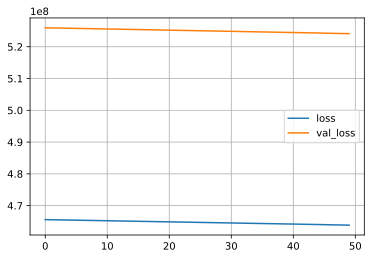

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.grid()
plt.legend()
plt.show()

## 結果の確認

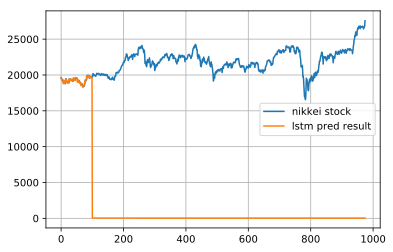

In [30]:
# 初期の入力値
res = l_y[0].reshape(-1)

for i in range(0, n):
  _y = model.predict(res[- NUM_LSTM:].reshape(1, NUM_LSTM, 1))
  res = np.append(res, _y[0][NUM_LSTM - 1][0])
  
plt.plot(np.arange(len(y)), y, label="nikkei stock")
plt.plot(np.arange(len(res)), res, label="lstm pred result")
plt.legend()
plt.grid()
plt.show()

In [24]:



import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row),:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(input_shape = (layers[1], layers[0]),
                    output_dim=layers[1],
                    return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer='rmsprop')
    print(" 実行時間：　", time.time() - start)
    return model

def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

 import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row),:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(input_shape = (layers[1], layers[0]),
                    output_dim=layers[1],
                    return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer='rmsprop')
    print(" 実行時間：　", time.time() - start)
    return model

def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs
 
"""
model.fit(X_train, y_train, batch_size=512, nb_epoch=epoch, validation_split=0.05)
predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
model = lstm.build_model([1, 50, 100, 1])
"""


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 95)